<a href="https://colab.research.google.com/github/Android998/TensorFlow2.3/blob/master/TFG2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Paso 1: Importar las librerias**

In [24]:
import os
import zipfile
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
import matplotlib.pyplot as plt

from tensorflow.keras.constraints import MaxNorm
from tqdm import tqdm_notebook
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## **Paso 2:Pre procesado de datos**

In [8]:
drive.mount("/content/drive")
base_dir = "./drive/My Drive/object_photos2.0"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)


In [48]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

print(len(train_generator))

Found 12801 images belonging to 40 classes.
1601


In [49]:
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')
print(len(val_generator))

Found 3200 images belonging to 40 classes.
400


### **Generamos el archivo labels con las etiquetas de los objetos**

In [13]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'backpack': 0, 'bed': 1, 'belt': 2, 'blind stick': 3, 'bottle': 4, 'carpet': 5, 'cellular phone': 6, 'chair': 7, 'cup-glass': 8, 'door': 9, 'eyeglasses': 10, 'fan': 11, 'handkerchief': 12, 'headphones': 13, 'keys': 14, 'laptop': 15, 'mouse': 16, 'newspaper': 17, 'notebook': 18, 'pen': 19, 'pencil': 20, 'pillow': 21, 'plate': 22, 'plug': 23, 'printer': 24, 'radiator': 25, 'remote control': 26, 'shoes': 27, 'shorts': 28, 'socks': 29, 't-shirts': 30, 'table': 31, 'television': 32, 'toothbrush': 33, 'towel': 34, 'trash bin': 35, 'wallet': 36, 'wardrobe': 37, 'watch': 38, 'window (shade)': 39}


In [ ]:
!cat labels.txt

backpack
bed
belt
blind stick
bottle
carpet
cellular phone
chair
cup-glass
door
eyeglasses
fan
handkerchief
headphones
keys
laptop
mouse
newspaper
notebook
pen
pencil
pillow
plate
plug
printer
radiator
remote control
shoes
shorts
socks
t-shirt
table
television
toothbrush
towel
trash bin
wallet
wardrobe
watch
window (shade)

## **Paso 3: Crear el modelo base ya entrenado**

In [14]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [39]:
modelo = tf.keras.models.Sequential()
modelo.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=IMG_SHAPE))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
modelo.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
modelo.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
modelo.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
modelo.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Flatten())
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.Dense(units=256, activation="relu"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Dense(units=128, activation="relu"))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Dense(units=40, activation="softmax"))

In [40]:
modelo.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
dropout_71 (Dropout)         (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 112, 112, 64)    

In [50]:
modelo.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [52]:
history = modelo.fit(train_generator, 
           steps_per_epoch=len(train_generator), 
           epochs=20,
           validation_data=val_generator, 
           validation_steps=len(val_generator))

Epoch 1/20
1601/1601 [==============================] - 112s 70ms/step - loss: 1.2650 - accuracy: 0.6282 - val_loss: 4.2032 - val_accuracy: 0.1912
Epoch 2/20
1601/1601 [==============================] - 112s 70ms/step - loss: 1.3303 - accuracy: 0.6139 - val_loss: 4.2427 - val_accuracy: 0.1909
Epoch 3/20
1601/1601 [==============================] - 112s 70ms/step - loss: 1.2672 - accuracy: 0.6263 - val_loss: 4.4356 - val_accuracy: 0.1822
Epoch 4/20
1601/1601 [==============================] - 112s 70ms/step - loss: 1.3352 - accuracy: 0.6085 - val_loss: 4.2152 - val_accuracy: 0.1872
Epoch 5/20
1601/1601 [==============================] - 112s 70ms/step - loss: 1.3330 - accuracy: 0.6114 - val_loss: 4.4498 - val_accuracy: 0.1900
Epoch 6/20
1601/1601 [==============================] - 113s 71ms/step - loss: 1.2527 - accuracy: 0.6251 - val_loss: 4.5185 - val_accuracy: 0.1916
Epoch 7/20
1601/1601 [==============================] - 113s 70ms/step - loss: 1.2519 - accuracy: 0.6302 - val_loss: 5

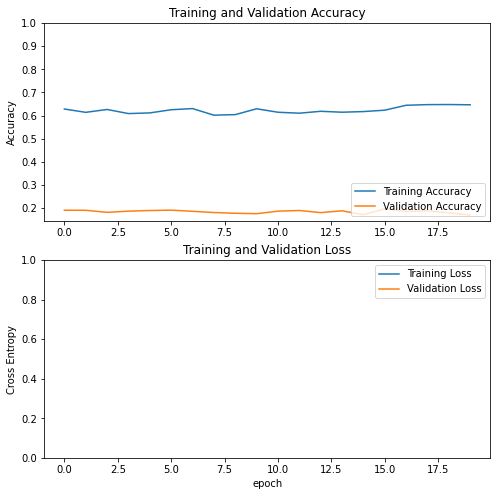

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()